<h1>DLPy Speech Training Example</h1>

The following SAS DLPy example trains a speech model on an RNN network. The example uses a toy data set that is created in the code. 

The example assumes that you have already started a CAS server and you know the port number associated with that server. Also, both the Graphviz binaries/program and python package are required to run this notebook. 

<h3>Start a CAS Session and Import SWAT</h3>

SAS DLPy requires a running SAS CAS server and a package called the Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to SAS Cloud Analytic Services (CAS). SWAT enables you to load data into memory and apply CAS actions to transform, summarize, model, and score the data.  

When you import SWAT you must provide the name of your `cashost` and `casport`.

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [1]:
import swat
s = swat.CAS(cashost, casport)

<h3>Import DLPy Package and Classes</h3>

Now import and configure the DLPy API for the training. 

First, import the `Sequential` class for network models. Then import the `TextParms`, `DataSpec`, and `DataSpecNumNomOpts` classes from `dlpy.model`. Finally, import the `Bidirectional` class from `dlpy.blocks`, and the `SpeechRecognition` class from `dlpy.applications`.

In [2]:
# Import DLPy
import dlpy
from dlpy import Sequential
from dlpy import *
from dlpy.model import TextParms, DataSpec, DataSpecNumNomOpts
from dlpy.blocks import Bidirectional
from dlpy.applications import SpeechRecognition

<h3>Create Example Data</h3>


Now create a toy data set to use with the example. This toy data set uses x0-x9 as the input columns and y0-y4 as target columns. 

The data sets are read into memory in a later step. The `try: catch` block provides compatibility across Python versions when importing the `StringIO` libraries.  

Use a data handler and the `addtable()` function to upload recently created `toytext_training` into a CAS table, `TOYTEXT_TRAINING`.


In [3]:
# Create a toy dataset
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import swat.cas.datamsghandlers as dmh

toytext = StringIO('''x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,xlen,ylen,y0,y1,y2,y3,y4
                    0.1,0.11,-0.2,-0.21,-0.25,-0.26,-0.7,-0.76,0.78,0.80,10,4,'b ', 'o ', 'o ','k ', '<>'
                    0.8, 0.78,0.2, 0.18,0.11,0.12,0.5,0.56,0,0,8,4,'l ','a ', 'm ', 'p ', '<>'
                    0.12,0.11, 0.3,0.32, -0.5,-0.56,0,0,0,0,6,3,'m ', 'e ', 'h ', '<>', '<>'
                    0.92, 0.90,-0.26, -0.24,0, 0,0,0,0,0,4,2,'n ', 'o ', '<>', '<>', '<>'
                    ''')
handler = dmh.CSV(toytext, skipinitialspace=True)
s.addtable(table='toytext_training', replace=True, **handler.args.addtable)

[caslib]

 'CASUSER(ethem_kinginthenorth)'

[tableName]

 'TOYTEXT_TRAINING'

[casTable]

 CASTable('TOYTEXT_TRAINING', caslib='CASUSER(ethem_kinginthenorth)')

+ Elapsed: 0.00397s, user: 0.00111s, sys: 1e-05s, mem: 1.13mb

You can see in the results above that the CAS table "TOYTEXT_TRAINING" is created.



<h3>Create Acoustic Model</h3>

Next, create an acoustic model. The acoustic model should have 1 block and 15 neurons.

In [4]:
# create an acoustic model
model = SpeechRecognition(s, neurons=15, n_blocks=1)

NOTE: Output layer added.
NOTE: Model compiled successfully.


<h3>Visualize the Network</h3>

Use `plot_network()` (from Graphviz library) to visualize the newly created acoustic model network.

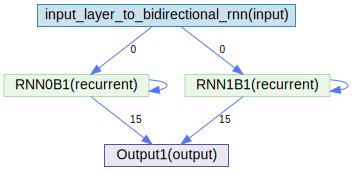

In [5]:
model.plot_network()

<h3>Train the Acoustic Model</h3>

Now train the acoustic model using the `Model.fit()` function. Use DataSpec to define the input and output parameters. 

The input layer is numeric and the output layer is nominal (characters). 

The model training uses the `toytext_training` data, is constrained to 5 epochs, and has a learning rate of 0.001. The log level is configured for basic reporting. 

In [6]:
# Training acoustic model
# dataspec layer names should be the same as the layer names in the model

model.fit(data='toytext_training', 
          data_specs=[DataSpec(type_='numericnominal', layer='input_layer_to_bidirectional_rnn', 
                               data=['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9'], 
                               numeric_nominal_parms=DataSpecNumNomOpts(token_size=2, length='xlen')), 
                     DataSpec(type_='numericnominal', layer='Output1', 
                              data=['y0','y1','y2','y3','y4'], 
                              numeric_nominal_parms=DataSpecNumNomOpts(token_size=1,length='ylen'))],
          max_epochs=5, lr=0.001, log_level=2)

NOTE: Training from scratch.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 1992.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Target variable: y0
NOTE:  Number of levels for the target variable:     12
NOTE:  Levels for the target variable:
NOTE:  Level      0: 'b '
NOTE:  Level      1: 'm '
NOTE:  Level      2: 'l '
NOTE:  Level      3: 'n '
NOTE:  Level      4: 'e '
NOTE:  Level      5: 'a '
NOTE:  Level      6: 'o '
NOTE:  Level      7: 'h '
NOTE:  Level      8: '<>'
NOTE:  Level      9: 'k '
NOTE:  Level     10: 'p '
NOTE:  Level     11:     
NOTE:  Number of input variables:    10
NOTE:  Number of numeric input variables:     10
NOTE:  Epo

,Descr,Value
0,Model Name,acoustic_model
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,1890


The resulting acoustic model has 4 layers: 1 input layer, 2 recurrent layers (1 forward layer and 1 backward layer making up the bidirectional layer), and 1 output layer. The model has 1,992 parameters. 

After the 5 epochs, the model loss rate come to 9.992. You may get a difference loss value since the `seed` parameter is set to 0 by default, and thus random number streams based on the computer clock will be used in SGD (Reference: https://sassoftware.github.io/python-dlpy/generated/dlpy.model.Model.fit.html).